# Tesina: The economics behind two-sided markets: key determinants of Airbnb pricing in Mexico City

## Edgar Robles Díaz

### Fuente principal: Inside Airbnb (Murray Cox)


### Parte 1. Procesamiento y limpieza de datos 

El propósito de esta tesina es encontrar los principales determinantes de los precios de los listados de Airbnb en la Ciudad de México, para ellos utilizaremos la información provista por Murray Cox en su página, Inside Airbnb. En esta, se publican scrapes mensuales de diversas ciudades del mundo donde Airbnb tiene presencia. Esta información incluye atributos del anfitrión, ubicación, precios, características, reglas y amenidades de los listados. Para este estudio utlilizaremos la información de los listados de la CDMX desde abril de 2019 hasta marzo de 2020. 

Debido al surgimiento de la pandemia y su eventual efecto en la industria del alojamiento, el estudio se limitará hasta febrero de 2020 con el fin de no incluir sesgos en la demanda y en los precios provocados por la pandemia.

Este notebook contiene la preparación de los datos publicados, en particular se limpiarán variables, se removerán aquellas que no sean de interés, se concatenará toda la información temporal y se van a extraer características adicional contenidas en listas dentro de las bases.

### Importar paquetería, configurara opciones de visualización y comfigurar el directorio ###

In [630]:
import pandas as pd
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
%matplotlib inline
import os

In [631]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [632]:
### Función para identificar listados ###
def SearchID(df, ident):
    return df[df['id'] == ident]

In [633]:
os.chdir('c:\\Users\\edari\\Desktop\\CIDE\\8 Octavo\\SEMINARIO DE TITULACIÓN\\Manejo de Datos\\Código tesina\\InsideAB&B')

In [634]:

### Introducir una lista con todo el directorio ###

dire = [
    'listings_adv_0319.csv',
    'listings_adv_0419.csv',
    'listings_adv_0519.csv',
    'listings_adv_0619.csv',
    'listings_adv_0719.csv',
    'listings_adv_0819.csv',
    'listings_adv_0919.csv',
    'listings_adv_1019.csv',
    'listings_adv_1119.csv',
    'listings_adv_1219.csv',
    'listings_adv_0120.csv',
    'listings_adv_0220.csv',
    'listings_adv_0320.csv'
]

### Pre-Processing

### Leer el Csv ###

listados_total = [pd.read_csv(d, low_memory = False) for d in dire]

In [635]:
### Establecer cuales son las variables redundantes y guardarlas en una lista ###

variables_red = ['listing_url', 'name', 'summary', 
            'space', 'description', 'host_id', 'host_location', 'host_response_rate', 'host_since',
            
            'experiences_offered',
            'neighborhood_overview', 'notes', 'transit',
            'access', 'interaction', 'house_rules',
                 
            'thumbnail_url',
            'medium_url', 'picture_url', 'xl_picture_url',
                 
            'host_url', 'host_name',
            'host_about',
            'host_thumbnail_url', 'host_picture_url','host_listings_count',
            'host_verifications', 
                 
            'street','neighbourhood_group_cleansed',
            'city','state','market','smart_location','country_code', 'country',
                 
            'bed_type',
                 
            'minimum_nights',
            'maximum_nights', 'minimum_minimum_nights',
            'maximum_minimum_nights', 'minimum_maximum_nights',
            'maximum_maximum_nights',
                 
                 
             "review_scores_accuracy",            
             "review_scores_cleanliness",         
             "review_scores_checkin",             
             "review_scores_communication",       
             "review_scores_location",            
             "review_scores_value",
                             
               'has_availability',  
                 
            'number_of_reviews_ltm',
            'reviews_per_month',   
                 
            'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
            'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms',
                 
            'is_business_travel_ready',
                 
            'host_response_time',
            'host_acceptance_rate',
            'scrape_id',
            'host_neighbourhood',
            'square_feet',
            'weekly_price',
            'monthly_price',
            'minimum_nights_avg_ntm',
            'maximum_nights_avg_ntm',
            'calendar_updated',
            'availability_30',
            'availability_60',
            'availability_90',
            'availability_365','calendar_last_scraped','requires_license',
            'license',
            'jurisdiction_names'   
            
                ]

# Quitar variables redundantes para el análisis

for l in listados_total:
    l.drop(columns=variables_red, inplace=True)

### Renombrar ###

for lis in listados_total:
    lis.rename(columns={'neighbourhood':'colonia',
                        'neighbourhood_cleansed':'alcaldía',
                        'zipcode':'código_postal',
                        'room_type':'tipo_cuarto',
                        'price':'precio',
                        'instant_bookable':'insta_book',
                        }, inplace = True)

### Limpieza de precios 

In [636]:
##### Primero hay que limpiar los precios, es decir, quitarle el signo y puntuación y convertirlo a tipo flotante #####

### Establecer varaibles de precio

prices = ['precio','cleaning_fee','extra_people', 'security_deposit']

for lista in listados_total:
    for p in prices:
        lista[p] = lista[p].str.replace('$','')
        lista[p] = lista[p].str.replace(',','')
        lista[p] = pd.to_numeric(lista[p])

### Sustituir NAs en variables de precios adicionales (i.e. poner 0 en listados que no cuentan con precios adicionales)        
        
for lista in listados_total:
    for p in prices[1:]:
        lista[p] = lista[p].fillna(0)

### Concatenar, ordenar, crear variable host profesional y reofrmatear variables a datetime 

In [637]:

### Concatenar todas las bases de 04-19 a 03-20 en una sola y ordenarlas por id y fecha

listados_panel = pd.concat(listados_total)

#### Ordenar el df por id y fecha de scrapeo ###

listados_panel.sort_values(by=['id', 'last_scraped'], inplace=True)

listados_panel.drop_duplicates(subset=['id', 'last_scraped'], inplace=True)

##### Crear variable comercial, es decir, si el dueño del listado tiene más de uno, es comercial, si es sólo uno, entonces es privado

listados_panel['Tipo Listado'] = np.where(listados_panel['host_total_listings_count'] > 1, 1, 0)

# Convertir variables a datetime

listados_panel['last_scraped'] = pd.to_datetime(listados_panel['last_scraped'])

listados_panel['mes'] = pd.to_datetime(listados_panel['last_scraped']).dt.to_period('M')



### Filtrar listados cuyo precio sea igual a cero ### 

In [638]:
zero_price_index = listados_panel[listados_panel['precio'] == 0.0].index
listados_panel.drop(zero_price_index, axis = 0, inplace = True)

### Limpiar variable de amenidades y seleccionar amenidades de interés para el estudio 

In [639]:
listados_panel.amenities = listados_panel.amenities.str.replace("[{}]", "").str.replace('"', "").str.replace(' ','_').str.replace(' ','').str.lower()

amenities = ['wifi', 'pets_allowed', 'gym', 'breakfast', 
             'kitchen', 'washer', 'dryer', 'parking',
             'elevator', 'pool', 'smoking_allowed', 
             'hot_tub']


for a in amenities:
    listados_panel[a] = listados_panel.amenities.str.contains(a)
    listados_panel[a] = listados_panel[a].replace(False, 0, regex=True)
    listados_panel[a] = listados_panel[a].replace(True, 1, regex=True)

In [640]:
listados_panel = listados_panel.drop(axis=1, columns='amenities')

### Convertir variables t o f a dummies de 0/1

In [641]:
columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'insta_book',
                   'require_guest_profile_picture', 'require_guest_phone_verification']
for c in columns:
    listados_panel[c] = listados_panel[c].replace('f',0,regex=True)
    listados_panel[c] = listados_panel[c].replace('t',1,regex=True)

### Filtrar los cuartos de hotel, solo nos interesan unidades enteras, cuartos privados y espacios compartidos

In [642]:
ids_hotel = listados_panel[listados_panel['tipo_cuarto'] == 'Hotel room']['id']

In [643]:
ids_hotel = indices_hotel.drop_duplicates()

### Seleccionar listados publicados en el mes de julio ###

In [644]:
listados_panel = listados_panel[listados_panel['mes'] == '2019-07-01']
listados_panel.drop('mes', axis=1, inplace=True)

In [645]:
indices_hotel = listados_panel[listados_panel['id'].isin(ids_hotel)].index
listados_panel.drop(indices_hotel,  inplace = True)

### Filtrar listados cuya ubicación es inexacta ###

<AxesSubplot:>

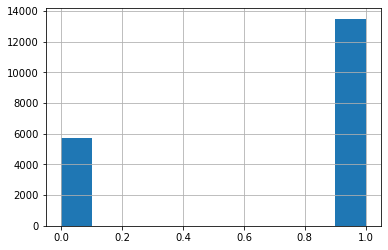

In [646]:
listados_panel.is_location_exact.hist()

In [647]:
indices_ubis =listados_panel[listados_panel['is_location_exact'] == False].index
listados_panel = listados_panel.drop(indices_ubis)
listados_panel.drop(axis=1, columns='is_location_exact', inplace=True)

### Filtrar listados que no cuentan con información de que usuarios son Superhosts ###

<AxesSubplot:>

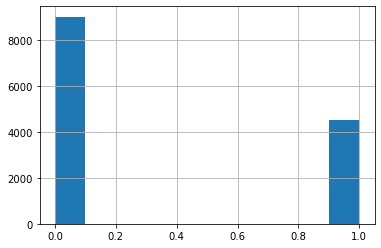

In [648]:
listados_panel.host_is_superhost.hist()

In [649]:
listados_panel.host_is_superhost.isnull().sum()

6

In [650]:
super_index = listados_panel[listados_panel.host_is_superhost.isnull() == True].index
listados_panel.drop(super_index, inplace = True)

### Imputar la mediana a listados sin ratings 

<AxesSubplot:>

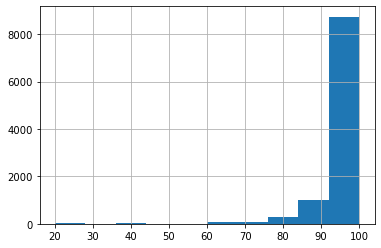

In [651]:
listados_panel.review_scores_rating.hist(bins=10)

In [652]:
listados_panel.review_scores_rating.isnull().sum()

3209

In [653]:
mediana = listados_panel.review_scores_rating.median()
mediana

98.0

In [654]:
listados_panel.review_scores_rating.fillna(mediana, inplace=True)

### Repetir el mismo proceso a camas, habitaciones y baños

In [655]:
## NAs de número de recámaras, baños y camas 

In [656]:
# Imprimir número de missing values (izquierda) y mediana (derecha)

In [657]:
size = ['bedrooms', 'bathrooms', 'beds']

for i in size:
    print(listados_panel[i].isnull().sum(), listados_panel[i].median())

4 1.0
6 1.0
11 1.0


In [658]:
for i in size:
    listados_panel[i].fillna(listados_panel[i].median(), inplace=True)

### Estimar periodo de inactividad y filtrar los resultados 

In [659]:
### Convertir variables a datetime ###

listados_panel['first_review'] = pd.to_datetime(listados_panel['first_review'])

listados_panel['last_review'] = pd.to_datetime(listados_panel['last_review'])

listados_panel['meses_inact'] = ((listados_panel.last_scraped - listados_panel.last_review)/np.timedelta64(1, 'M'))

listados_panel['ad_duration'] = ((listados_panel.last_scraped - listados_panel.first_review)/np.timedelta64(1, 'M'))



index_inact = listados_panel[(listados_panel['meses_inact'] > 6)].index
index_null_act = listados_panel[listados_panel.meses_inact.isnull() == True].index


listados_panel.drop(index_inact, inplace=True)
listados_panel.drop(index_null_act, inplace=True)


listados_panel.drop(columns=['meses_inact', 'last_scraped'], inplace= True)

### Filtrar por tipo de propiedad, selección de apartamentos, lofts y departamentos con servicios

Para el estudio, utilizaremos una muestra de tipo de propiedad más específica, de acuerdo con (Chica-Olmo et al. 2020), es preferible estudiar una muestra homogénea de tipo de propiedad debido a la difrenciación que existe entre los servicios ofrecidos. (e.g. no es posible hacer una comparación exacta entre tipos de alojamiento especiales, como es el caso de Bungalows, cabañas y cuevas frente a hoteles. Tampoco es factible comprar listados que se señalizan como hoteles o Bed & Breakfasts) El propósito es el de homogeneizar la muestra a un grupo particular para obtener resultados limpios y específicos para esta muestra. En este caso, se decidió que se analizará únicamente a los departamentos debido a que prevalecen como  una mayoría en la muestra y nos permitirá depejar efectos de otros tipos de alojamiento. Además, el spillover espacial será menos hetrogéneo. 

In [660]:
listados_panel.property_type.value_counts()

Apartment                  5442
House                       957
Condominium                 559
Loft                        525
Serviced apartment          280
Guest suite                 202
Bed and breakfast            84
Guesthouse                   79
Hostel                       75
Boutique hotel               45
Townhouse                    44
Tiny house                   16
Hotel                        16
Casa particular (Cuba)       15
Aparthotel                   13
Other                        13
Villa                         6
Cabin                         3
Nature lodge                  2
Cycladic house (Greece)       2
Chalet                        2
Bungalow                      2
Farm stay                     2
Cave                          1
Barn                          1
Dome house                    1
Name: property_type, dtype: int64

In [661]:
indices_prop = listados_panel[listados_panel['property_type'].isin(['Apartment', 'Loft', 'Serviced apartment'])].index
listados_panel = listados_panel.loc[indices_prop]
listados_panel.drop(columns='property_type', inplace =True)

### Categorizar tipo de cuarto y política de cancelación

In [662]:
listados_panel.cancellation_policy = listados_panel.cancellation_policy.apply(lambda x:1 if x=='flexible' else 0)

In [663]:
listados_panel.rename({'cancellation_policy':'flexible_cancel'}, axis = 1, inplace = True)

In [664]:
listados_panel.flexible_cancel.value_counts()

0    3958
1    2289
Name: flexible_cancel, dtype: int64

In [665]:
listados_panel['flexible_cancel'] = listados_panel['flexible_cancel'].astype('int')

In [666]:
listados_panel = pd.concat((listados_panel, pd.get_dummies(listados_panel['tipo_cuarto'])), axis = 1).drop(['Entire home/apt', 'tipo_cuarto'], axis = 1)

In [667]:
listados_panel['Private room'] = listados_panel['Private room'].astype(int)
listados_panel['Shared room'] = listados_panel['Shared room'].astype(int)

In [668]:
listados_panel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6247 entries, 5 to 19250
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                6247 non-null   int64         
 1   host_is_superhost                 6247 non-null   float64       
 2   host_total_listings_count         6247 non-null   float64       
 3   host_has_profile_pic              6247 non-null   float64       
 4   host_identity_verified            6247 non-null   float64       
 5   colonia                           5564 non-null   object        
 6   alcaldía                          6247 non-null   object        
 7   código_postal                     6166 non-null   object        
 8   latitude                          6247 non-null   float64       
 9   longitude                         6247 non-null   float64       
 10  accommodates                      6247 non-null

In [669]:
listados_panel['código_postal'] = listados_panel['código_postal'].str.replace('CP', '')

In [670]:
listados_panel['código_postal'] = listados_panel['código_postal'].str.replace('cp.', '')

In [671]:
listados_panel['código_postal'] = listados_panel['código_postal'].str.replace('Ciudad de Mexico', '')

In [672]:
listados_panel['código_postal'] = listados_panel['código_postal'].str.replace(' ', '')

In [673]:
listados_panel['ln_price'] = np.log(listados_panel['precio'])

In [674]:
listados_panel.set_index('id', inplace = True)

### Exportar datos finales a un CSV ###

In [675]:
listados_panel.to_csv('inside_abnb_clean.csv',encoding='latin1')

### Código para el estudio pasado (Estimar la ocupación con base en información desagregada de reseñas en una bd externa de Airbnb)

In [ ]:
reviews  = pd.read_csv("reviews_clean.csv")

reviews.rename(columns={'reviews_per_month':'reviews_per_month_2'}, inplace=True)

reviews.info()

reviews.drop('Unnamed: 0', axis = 1, inplace = True)

reviews.mes = pd.to_datetime(reviews.mes)

listados_panel.mes = listados_panel.mes.astype('str')

listados_panel.mes = pd.to_datetime(listados_panel.mes)

#### Agregar datos de número de reseñas por mes por listado a la base de datos principal ###

listados_panel = listados_panel.merge(reviews, on=['mes', 'id'], how = 'left')



### Estimar la ocupación de los listados ###

### Primero hay que estimar el número de noches promedio de los huéspedes en la CDMX. 4 noches, según el Financiero en 2017.

noches_promedio = 4

### Luego hay que calcular la tasa de reviews (Inside Airbnb/Murray Cox)

tasa_reviews_1 = 0.5

tasa_reviews_2 = 0.4

listados_panel['occupancy_rate_1'] = round(noches_promedio*(listados_panel['reviews_per_month']/tasa_reviews_1), 2)

listados_panel['occupancy_rate_2'] = round(noches_promedio*(listados_panel['reviews_per_month']/tasa_reviews_2), 2)

listados_panel['occupancy_rate_3'] = round(noches_promedio*(listados_panel['reviews_per_month_2']/tasa_reviews_1), 2)

### Quitamos outliers que no cumplen con las condiciones

len(listados_panel[listados_panel['occupancy_rate_1'] > 100])

listados_panel.drop(listados_panel[(listados_panel['occupancy_rate_1'] > 100)].index, axis=0, inplace=True)
listados_panel.occupancy_rate_1.describe()

ids_hoteles = list(listados_panel[listados_panel['tipo_cuarto'] == 'Hotel room']['id'])
indices = list(listados_panel[listados_panel['id'].isin(ids_hoteles)].sort_values(by='id')['tipo_cuarto'].index)

listados_panel.loc[indices,'tipo_cuarto'] = 'Hotel room'